# Save datasets to a ROOT file after processing

With RDataFrame, you can read your dataset, add new columns with processed values and finally use `Snapshot` to save the resulting data to a ROOT file in TTree format.

In [1]:
import ROOT

df = ROOT.RDataFrame("dataset","../../data/example_file.root")
df1 = df.Define("c","a+b")

out_treename = "outtree"
out_filename = "outtree.root"
out_columns = ["a","b","c"]
snapdf = df1.Snapshot(out_treename, out_filename, out_columns)

Welcome to JupyROOT 6.30/04


We can now check that the dataset was correctly stored in a file:

In [2]:
%%bash
rootls -lt outtree.root

TTree  Jul 31 11:33 2024 outtree;1 "outtree" 
  a  "a/D"  16071
  b  "b/D"  16071
  c  "c/D"  16071
  Cluster INCLUSIVE ranges:
   - # 0: [0, 1999]
  The total number of clusters is 1


Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3001] Required argument not present


Result of a Snapshot is still an RDataFrame that can be further used:

In [3]:
snapdf.Display().Print()

+-----+------------+------------+------------+
| Row | a          | b          | c          | 
+-----+------------+------------+------------+
| 0   | 0.97771140 | 0.99974175 | 1.9774531  | 
+-----+------------+------------+------------+
| 1   | 2.2802012  | 0.48497361 | 2.7651748  | 
+-----+------------+------------+------------+
| 2   | 0.56348245 | 0.39231399 | 0.95579645 | 
+-----+------------+------------+------------+
| 3   | 3.0421559  | 0.33353925 | 3.3756951  | 
+-----+------------+------------+------------+
| 4   | 28.574399  | 0.64812557 | 29.222524  | 
+-----+------------+------------+------------+


Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3001] Required argument not present


# Cutflow reports
Filters applied to the dataset can be given a name. The `Report` method will gather information about filter efficiency and show the data flow between subsequent cuts on the original dataset.


In [4]:
df = ROOT.RDataFrame("sig_tree", "https://root.cern/files/Higgs_data.root")

filter1 = df.Filter("lepton_eta > 0", "Lepton eta cut")
filter2 = filter1.Filter("lepton_phi < 1", "Lepton phi cut")

rep = df.Report()
rep.Print()

Lepton eta cut: pass=4880       all=10000      -- eff=48.80 % cumulative eff=48.80 %
Lepton phi cut: pass=3842       all=4880       -- eff=78.73 % cumulative eff=38.42 %


# Using C++ functions in Python
- We still want to perform complex operations in Python but plain Python code is prone to be slow and not thread-safe. 

- Instead, you can inject C++ functions that will do the work in your event loop during runtime. 

- This mechanism uses the C++ interpreter `cling` shipped with ROOT, making this possible in a single line of code. 

- Let's start by defining a function that will allow us to change the type of a the RDataFrame dataset entry numbers (stored in the special column "rdfentry") from `unsigned long long` to `float`.

In [5]:
%%cpp

float asfloat(unsigned long long entrynumber){
    return entrynumber;
}

Then let's define another function that takes a `float` values and computes its square.

In [6]:
%%cpp

float square(float val){
    return val * val;
}

And now let's use these functions with RDataFrame! 

We start by creating an empty RDataFrame with 100 consecutive entries and defining new columns on it:

In [7]:
# Create a new RDataFrame from scratch with 100 consecutive entries
df = ROOT.RDataFrame(100)

# Create a new column using the previously declared C++ functions
df1 = df.Define("a", "asfloat(rdfentry_)")
df2 = df1.Define("b", "square(a)")

We can now plot the values of the columns in a graph:

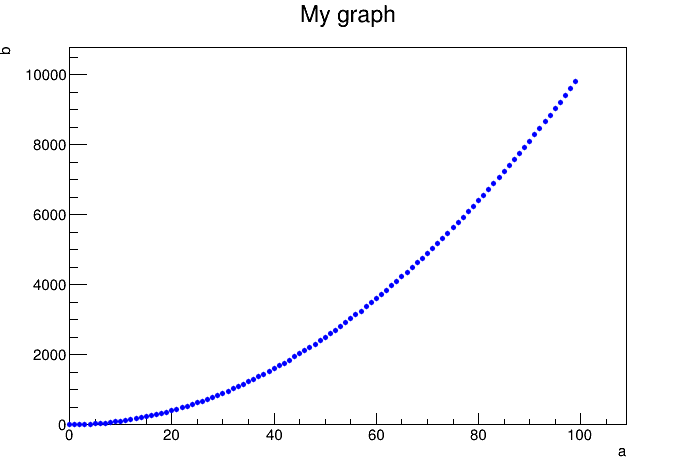

In [8]:
# Show the two columns created in a graph
c = ROOT.TCanvas()
graph = df2.Graph("a","b")
graph.SetMarkerStyle(20)
graph.SetMarkerSize(0.5)
graph.SetMarkerColor(ROOT.kBlue)
graph.SetTitle("My graph")
graph.Draw("AP")
c.Draw()

# Using all cores of your machine with multi-threaded RDataFrame
- RDataFrame can transparently perform multi-threaded event loops to speed up the execution of its actions. 

- Users have to call `ROOT::EnableImplicitMT()` before constructing the RDataFrame object to indicate that it should take advantage of a pool of worker threads. 

- Each worker thread processes a distinct subset of entries, and their partial results are merged before returning the final values to the user.

- RDataFrame operations such as Histo1D or Snapshot are guaranteed to work correctly in multi-thread event loops. 

- User-defined expressions, such as strings or lambdas passed to `Filter`, `Define`, `Foreach`, `Reduce` or `Aggregate` will have to be thread-safe, i.e. it should be possible to call them concurrently from different threads.

In [9]:
%%time
# Get a first baseline measurement

treename = "Events"
filename = "root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root"
df = ROOT.RDataFrame(treename, filename)

df.Sum("nMuon").GetValue()

CPU times: user 7.9 s, sys: 127 ms, total: 8.03 s
Wall time: 8.2 s


149322456.0

In [10]:
%%time
# Activate multithreading capabilities
# By default takes all available cores on the machine
ROOT.EnableImplicitMT()

treename = "Events"
filename = "root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root"
df = ROOT.RDataFrame(treename, filename)

df.Sum("nMuon").GetValue()

# Disable implicit multithreading when done
ROOT.DisableImplicitMT()

CPU times: user 43.1 s, sys: 121 ms, total: 43.3 s
Wall time: 11.2 s


Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 4 threads accordingly
